# Car Plate Symbols Detection

## Contents

- [EDA](#EDA)
- [Prepare Dataset for Training using YOLOv8](#prepare-dataset)
- [Train YOLO](#train-yolo)
- [TEST Dataset Validation](#test-dataset)
- [Inference](#Inference)

In [5]:
# %pip install -r requirements.txt

In [6]:
%load_ext autoreload
%autoreload 2

import os
import pathlib as Path
import xml.etree.ElementTree as ET
from shutil import copyfile
from typing import List, Tuple

import numpy as np
import pandas as pd
from tqdm import tqdm
from pathlib import Path

import cv2
from PIL import Image

import matplotlib.pyplot as plt

import ultralytics
from ultralytics import YOLO
ultralytics.checks()

Ultralytics YOLOv8.1.14 🚀 Python-3.9.10 torch-2.0.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
Setup complete ✅ (16 CPUs, 15.7 GB RAM, 425.6/618.9 GB disk)


In [7]:
DATA_PATH = "./data"
DATASET_PATH = "./datasets"

In [8]:
from utils.utils import seed_everything

seed_everything(42)

## EDA <a class="anchor" id="eda"></a>

## Files inventory

In [9]:
#Make dataframe with all files inventory
folders = ['train', 'test']
list_files_info = []

for folder in folders:
    for filename in os.listdir(os.path.join(DATA_PATH, folder)):
        file_type = filename.split('.')[-1]
        list_files_info.append([filename, filename.split('.')[-1], folder])

columns = ['filename', 'type', 'folder']
df_filepaths = pd.DataFrame(list_files_info, columns=columns)

df_filepaths.head(3)

filename  type folder
0  ckictsenl0000246a2itn28ts.jpeg  jpeg  train
1   ckictsenl0000246a2itn28ts.txt   txt  train
2   ckictsenl0000246a2itn28ts.xml   xml  train

In [10]:
#Explore number and type of files
df_filepaths['type'].value_counts()

type
txt     593
xml     593
jpeg    456
png     137
Name: count, dtype: int64

In [11]:
#Explore train/test ratio
df_filepaths[df_filepaths['type'] == 'txt']['folder'].value_counts()

folder
train    563
test      30
Name: count, dtype: int64

In [12]:
df_filepaths.to_csv(os.path.join(DATA_PATH, 'df_filepaths.csv'))

## Anotations TXT files processing

In [13]:
#Collect annotations for all images in one dataframe

columns = ['image_name', 'folder', 'class', 'center_X', 'center_y', 'width', 'height']
data = []

for i, row in df_filepaths.iterrows():
    if row['type']=='txt':
        file_path = os.path.join(DATA_PATH, row['folder'], row['filename'])
        
        with open(file_path, 'r') as file:
            for line in file:
                parts = line.split()
                annotation = [int(parts[0]), float(parts[1]), float(parts[2]), float(parts[3]), float(parts[4])]
                data.append([row['filename'].split('.')[0], row['folder']] + annotation)

annotations_df = pd.DataFrame(data, columns=columns)

# Display the first few rows of the DataFrame
annotations_df.head()

image_name folder  class  center_X  center_y     width  \
0  ckictsenl0000246a2itn28ts  train      0  0.114880  0.563636  0.041575   
1  ckictsenl0000246a2itn28ts  train      5  0.198031  0.527273  0.041575   
2  ckictsenl0000246a2itn28ts  train      2  0.288840  0.495455  0.048140   
3  ckictsenl0000246a2itn28ts  train      8  0.378556  0.490909  0.048140   
4  ckictsenl0000246a2itn28ts  train     18  0.589716  0.504545  0.054705   

     height  
0  0.618182  
1  0.672727  
2  0.754545  
3  0.745455  
4  0.736364

## XML files processing

In [14]:
from utils.utils import xml_to_dataframe

#Convert all xml files to dataframe and check for usefull information
all_data = []
for i, row in df_filepaths.iterrows():
    if row['type']=='xml':
        xml_path = os.path.join(DATA_PATH, row['folder'], row['filename'])
        flat_data = xml_to_dataframe(xml_path)
        all_data.append(flat_data)
df_xml = pd.concat(all_data, ignore_index=True)

In [15]:
df_xml.head(3)

name         pose  truncated  difficult  bndbox.xmin  bndbox.ymin  \
0    0  Unspecified          0          0           44           29   
1    5  Unspecified          0          0           82           22   
2    2  Unspecified          0          0          122           14   

   bndbox.xmax  bndbox.ymax                                      folder  \
0           63           97  From-Labelbox-license-characters-593images   
1          101           96  From-Labelbox-license-characters-593images   
2          144           97  From-Labelbox-license-characters-593images   

                         filename  \
0  ckictsenl0000246a2itn28ts.jpeg   
1  ckictsenl0000246a2itn28ts.jpeg   
2  ckictsenl0000246a2itn28ts.jpeg   

                                                path   source width height  \
0  /home/riotu/Object Detection/Datasets/Car-dete...  Unknown   457    110   
1  /home/riotu/Object Detection/Datasets/Car-dete...  Unknown   457    110   
2  /home/riotu/Object Detection/Datasets/Car-dete...  Unknown   457    110   

  depth segmented  
0     3         0  
1     3         0  
2     3         0

In [16]:
df_xml.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3827 entries, 0 to 3826
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   name         3827 non-null   object
 1   pose         3827 non-null   object
 2   truncated    3827 non-null   int64 
 3   difficult    3827 non-null   int64 
 4   bndbox.xmin  3827 non-null   int64 
 5   bndbox.ymin  3827 non-null   int64 
 6   bndbox.xmax  3827 non-null   int64 
 7   bndbox.ymax  3827 non-null   int64 
 8   folder       3827 non-null   object
 9   filename     3827 non-null   object
 10  path         3827 non-null   object
 11  source       3827 non-null   object
 12  width        3827 non-null   object
 13  height       3827 non-null   object
 14  depth        3827 non-null   object
 15  segmented    3827 non-null   object
dtypes: int64(6), object(10)
memory usage: 478.5+ KB


In [17]:
#Check null columns and if all immages have 3 channels (column 'depth')
null_columns = ['pose', 'truncated', 'difficult', 'segmented', 'depth']
for column in null_columns:
    print(column, df_xml[column].value_counts())

pose pose
Unspecified    3827
Name: count, dtype: int64
truncated truncated
0    3827
Name: count, dtype: int64
difficult difficult
0    3827
Name: count, dtype: int64
segmented segmented
0    3827
Name: count, dtype: int64
depth depth
3    3827
Name: count, dtype: int64


In [18]:
#Column 'name' contains class names (numbes and letters)
df_xml['name'].value_counts()

name
7    276
3    269
5    263
J    252
2    245
0    225
4    225
9    204
D    199
8    184
6    181
B    174
A    165
1    158
N    109
X     86
L     72
Z     72
V     70
S     66
T     58
K     49
H     49
G     48
R     48
E     43
U     37
Name: count, dtype: int64

In [19]:
#Delete all unnecessary columns in xml dataframe
columns = df_xml.columns
items_to_keep = ['name', 'filename']
columns_drop = [item for item in columns if item not in items_to_keep]
df_xml.drop(columns=columns_drop, inplace=True)
df_xml.rename(columns={'name': 'class_name'}, inplace=True)
df_xml.head(5)

class_name                        filename
0          0  ckictsenl0000246a2itn28ts.jpeg
1          5  ckictsenl0000246a2itn28ts.jpeg
2          2  ckictsenl0000246a2itn28ts.jpeg
3          8  ckictsenl0000246a2itn28ts.jpeg
4          L  ckictsenl0000246a2itn28ts.jpeg

## Merge TXT and XML annotations 

In [20]:
#Merge 
df_merge = pd.merge(annotations_df, df_xml, left_index=True, right_index=True, how='inner')

#Add column with image size
df_merge['im_size'] = None
for i, row in df_merge.iterrows():
    img_path = os.path.join(DATA_PATH, row['folder'], row['filename'])
    image = Image.open(img_path)
    im_size = image.size
    df_merge.at[i, 'im_size'] = im_size

df_merge.head()

image_name folder  class  center_X  center_y     width  \
0  ckictsenl0000246a2itn28ts  train      0  0.114880  0.563636  0.041575   
1  ckictsenl0000246a2itn28ts  train      5  0.198031  0.527273  0.041575   
2  ckictsenl0000246a2itn28ts  train      2  0.288840  0.495455  0.048140   
3  ckictsenl0000246a2itn28ts  train      8  0.378556  0.490909  0.048140   
4  ckictsenl0000246a2itn28ts  train     18  0.589716  0.504545  0.054705   

     height class_name                        filename     im_size  
0  0.618182          0  ckictsenl0000246a2itn28ts.jpeg  (457, 110)  
1  0.672727          5  ckictsenl0000246a2itn28ts.jpeg  (457, 110)  
2  0.754545          2  ckictsenl0000246a2itn28ts.jpeg  (457, 110)  
3  0.745455          8  ckictsenl0000246a2itn28ts.jpeg  (457, 110)  
4  0.736364          L  ckictsenl0000246a2itn28ts.jpeg  (457, 110)

In [21]:
#check if merge is correct and create Classes Dictionary
fr_of_class_names= df_merge.groupby('class')['class_name'].value_counts()
class_dict = dict(fr_of_class_names.index)
class_dict

{0: '0',
 1: '1',
 2: '2',
 3: '3',
 4: '4',
 5: '5',
 6: '6',
 7: '7',
 8: '8',
 9: '9',
 10: 'A',
 11: 'B',
 12: 'D',
 13: 'E',
 14: 'G',
 15: 'H',
 16: 'J',
 17: 'K',
 18: 'L',
 19: 'N',
 20: 'R',
 21: 'S',
 22: 'T',
 23: 'U',
 24: 'V',
 25: 'X',
 26: 'Z'}

## Bboxes visualization

In [22]:
#Function to visualize images with bboxes
def draw_bboxes(unique_images: List[str], datapath: str, folder: str, df: pd.DataFrame, figsize: Tuple[int, int] = (15, 5), plot_row: int = 3, plot_col: int = 4):
    plt.figure(figsize=figsize)
    for i, image_file in enumerate(unique_images):
        img_path = os.path.normpath(os.path.join(datapath, folder, image_file))
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Filter dataframe for the current image
        image_data = df[df['filename'] == image_file]

        # Plot each bounding box
        for _, row in image_data.iterrows():
            height, width, _ = image.shape
            x_min = int((row['center_X'] - row['width'] / 2) * width)
            y_min = int((row['center_y'] - row['height'] / 2) * height)
            x_max = int((row['center_X'] + row['width'] / 2) * width)
            y_max = int((row['center_y'] + row['height'] / 2) * height)

            cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (255, 0, 0), 1)
            cv2.putText(image, row['class_name'], (x_min, y_max), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0, 0, 255), 1)

        # Create subplot for each image
        ax = plt.subplot(plot_row, plot_col, i + 1)
        ax.set_title(image_file, fontsize = 7)
        ax.imshow(image)
        ax.axis('off')
        
    plt.tight_layout()
    plt.show()

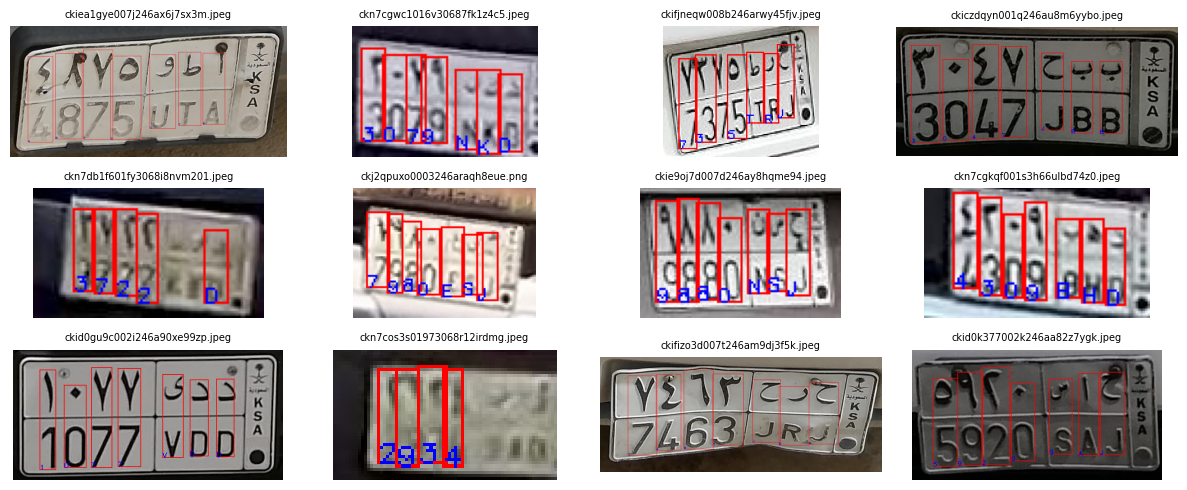

In [23]:
#Visualize sample images from train folder
NUM_IMAGES = 3 * 4
unique_images = np.random.choice(df_merge[df_merge['folder']=='train']['filename'].unique(), NUM_IMAGES, replace=False)
image_folder = os.path.join(DATA_PATH, 'train')

draw_bboxes(unique_images, datapath=DATA_PATH, df=df_merge, folder='train', figsize=(12, 5))

### Comments on Visualization of Annotated Images
The quality of the images varies, including some of very poor quality (characters are difficult to visually distinguish). Not all pairs of characters are annotated on some images.
Image preprocessing and filtering can be required

## Analysis of classes and bboxes

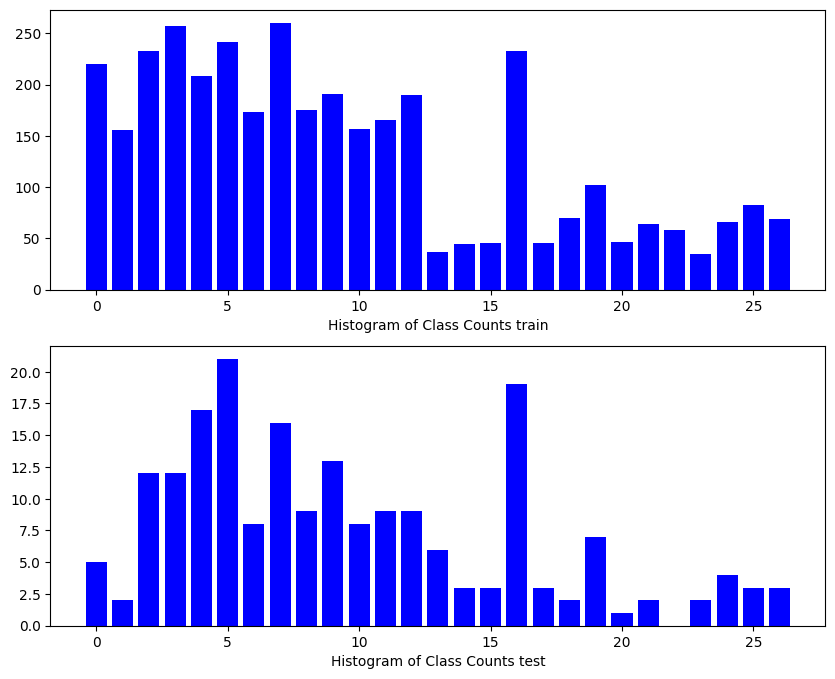

In [24]:
#Class Balance analysis

plt.figure(figsize=(10, 8))

for num, folder in enumerate(folders):
    ax = plt.subplot(2, 1, num + 1)
    class_count = annotations_df[annotations_df['folder'] == folder]['class'].value_counts()
    ax.bar(class_count.index, class_count.values, color='blue')
    ax.set_xlabel('Class ID')
    ax.set_xlabel('Count')
    ax.set_xlabel(f'Histogram of Class Counts {folder}')
plt.show()

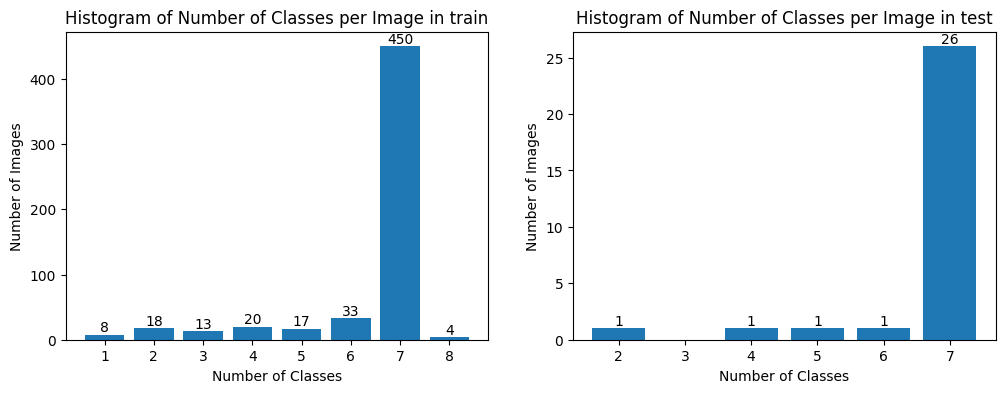

In [25]:
#Objects Count on each image in train and test datasets
plt.figure(figsize=(12, 4))

for num, folder in enumerate(folders):
    frequency_of_class_counts = annotations_df[annotations_df['folder'] == folder].groupby('image_name')['class'].count().value_counts()

    ax = plt.subplot(1, 2, num + 1)
    bars = ax.bar(frequency_of_class_counts.index, height=frequency_of_class_counts.values)

    for bar in bars:
        # Get the height of the bar (which represents the number of images)
        height = bar.get_height()
        # Annotate the bar with the count of images
        ax.text(bar.get_x() + bar.get_width() / 2, height, f'{int(height)}', ha='center', va='bottom')

    ax.set_xlabel('Number of Classes')
    ax.set_ylabel('Number of Images')
    ax.set_title(f'Histogram of Number of Classes per Image in {folder}')

plt.show()

In [26]:
#Classes Count on each image in train and test datasets
image_class_counts_train = df_merge[df_merge['folder'] == 'train'].groupby('filename')['class'].count()
image_class_counts_train = image_class_counts_train.reset_index()
image_class_counts_train.columns = ['image_name', 'class_count']

image_class_counts_test = df_merge[df_merge['folder'] == 'test'].groupby('filename')['class'].count()
image_class_counts_test = image_class_counts_test.reset_index()
image_class_counts_test.columns = ['image_name', 'class_count']

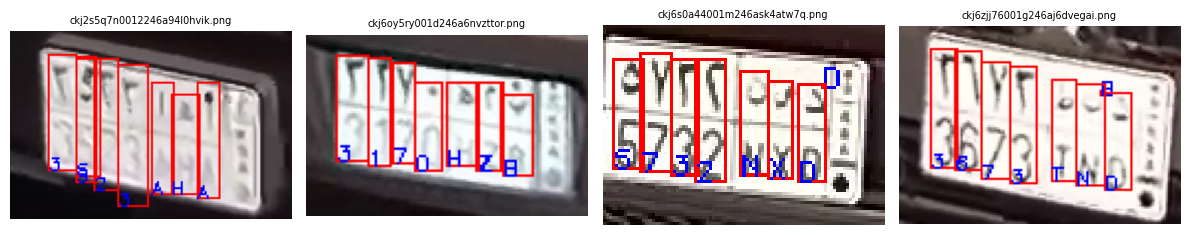

In [27]:
#Visualize images with outliers of small bboxes count 
folder = 'train'
n_bboxes = [8]

images_less_bboxes = []
for n_bbox in n_bboxes:
    images_less_bbox = image_class_counts_train[image_class_counts_train['class_count']==n_bbox]['image_name'].values
    for item in images_less_bbox:
        images_less_bboxes.append(item)

draw_bboxes(images_less_bboxes, datapath=DATA_PATH, df=df_merge, folder=folder, figsize=(12, 6), plot_row=1, plot_col=4)

#### It seems that there are inaccuracies in annotations: incorrect small bboxxes and bboxes dublicates / overlaps. These bboxes should be filtered

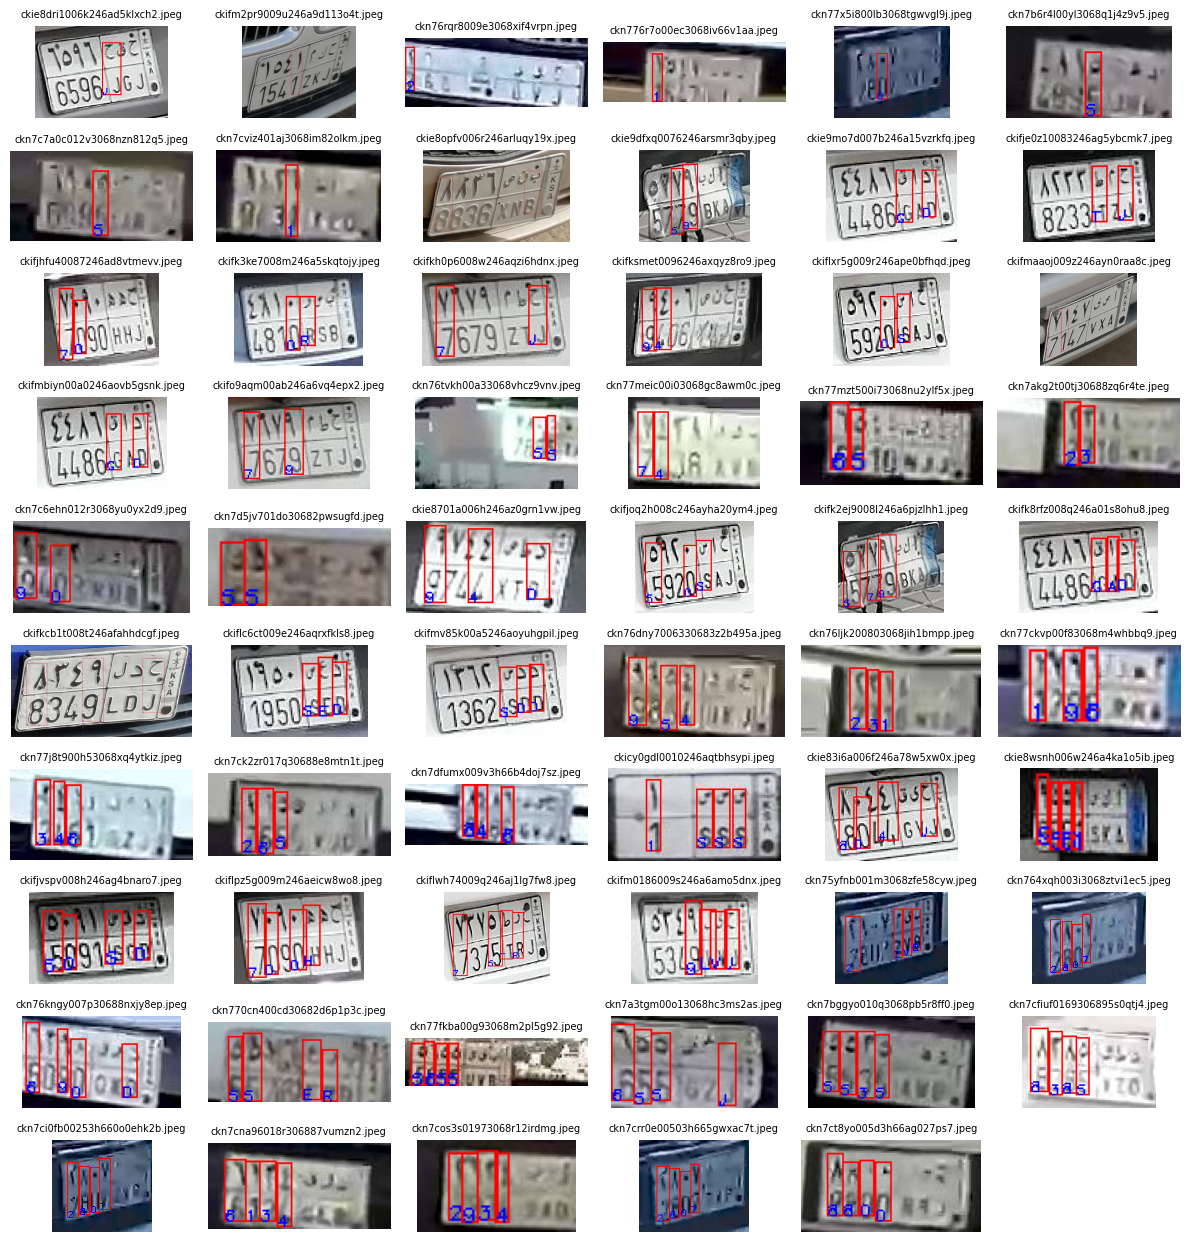

In [28]:
#Visualize images with outliers of bboxes count <5
folder = 'train'
n_bboxes = [1,2,3,4]

images_less_bboxes = []
for n_bbox in n_bboxes:
    images_less_bbox = image_class_counts_train[image_class_counts_train['class_count']==n_bbox]['image_name'].values
    for item in images_less_bbox:
        images_less_bboxes.append(item)

draw_bboxes(images_less_bboxes, datapath=DATA_PATH, df=df_merge, folder=folder, figsize=(12, 15), plot_row=12, plot_col=6)

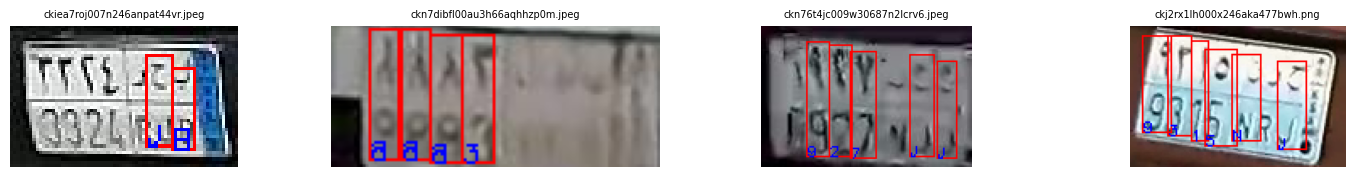

In [29]:
#Visualize images with outliers of bboxes count test
folder = 'test'
n_bboxes = [2,4,5,6]
images_less_bboxes = []
for n_bbox in n_bboxes:
    images_less_bbox = image_class_counts_test[image_class_counts_test['class_count']==n_bbox]['image_name'].values
    for item in images_less_bbox:
        images_less_bboxes.append(item)

draw_bboxes(images_less_bboxes, datapath=DATA_PATH, df=df_merge, folder=folder, figsize=(15, 5))

## Clean dataset from incorrect and overlapping bboxes

In [30]:
#Calculate bboxes area
df_merge['bbox_area_rel'] = df_merge['width'] * df_merge['height']
df_merge['bbox_area_abs'] = (df_merge['width'] * df_merge['im_size'].apply(lambda x: x[0])) * (df_merge['height'] * df_merge['im_size'].apply(lambda x: x[1]))

df_merge.sort_values(by='bbox_area_rel').head(5)

image_name folder  class  center_X  center_y     width  \
3462  ckn7cyduu006n3h66riht1e98  train      5  0.025362  0.033333  0.007246   
2492  ckj6s0a44001m246ask4atw7q  train     12  0.779570  0.295455  0.010753   
2879  ckj6zjj76001g246aj6dvegai  train     11  0.714844  0.333333  0.007812   
2109  ckifndgvd00a9246aa06cpuvg  train      1  0.232349  0.680328  0.038511   
1858  ckifk0r9c008k246adh7izqsv  train      0  0.398204  0.587269  0.043912   

        height class_name                        filename      im_size  \
3462  0.022222          5  ckn7cyduu006n3h66riht1e98.jpeg    (138, 45)   
2492  0.015152          D   ckj6s0a44001m246ask4atw7q.png     (93, 66)   
2879  0.022222          B   ckj6zjj76001g246aj6dvegai.png    (128, 90)   
2109  0.348946          1  ckifndgvd00a9246aa06cpuvg.jpeg   (779, 427)   
1858  0.308008          0  ckifk0r9c008k246adh7izqsv.jpeg  (1002, 487)   

      bbox_area_rel  bbox_area_abs  
3462       0.000161            1.0  
2492       0.000163            1.0  
2879       0.000174            2.0  
2109       0.013438         4470.0  
1858       0.013525         6600.0

In [31]:
#Calculate bboxes area statistics
df_merge['bbox_area_rel'].median(), df_merge['bbox_area_rel'].max()

(0.05811965811965813, 0.10901001112347052)

In [32]:
#Filter bboxes outlayers (area < 0.001)
df_merge_filterd = df_merge[df_merge['bbox_area_rel']>0.001]

df_merge_filterd.sort_values(by='bbox_area_rel').head()

image_name folder  class  center_X  center_y     width  \
2109  ckifndgvd00a9246aa06cpuvg  train      1  0.232349  0.680328  0.038511   
1858  ckifk0r9c008k246adh7izqsv  train      0  0.398204  0.587269  0.043912   
1895  ckifkdcpu008u246abrkusq9v  train      1  0.448604  0.584325  0.049492   
2108  ckifndgvd00a9246aa06cpuvg  train      1  0.139923  0.717799  0.043646   
2114  ckifndgvd00a9246aa06cpuvg  train     10  0.893453  0.310304  0.046213   

        height class_name                        filename      im_size  \
2109  0.348946          1  ckifndgvd00a9246aa06cpuvg.jpeg   (779, 427)   
1858  0.308008          0  ckifk0r9c008k246adh7izqsv.jpeg  (1002, 487)   
1895  0.319444          1  ckifkdcpu008u246abrkusq9v.jpeg   (788, 504)   
2108  0.362998          1  ckifndgvd00a9246aa06cpuvg.jpeg   (779, 427)   
2114  0.348946          A  ckifndgvd00a9246aa06cpuvg.jpeg   (779, 427)   

      bbox_area_rel  bbox_area_abs  
2109       0.013438         4470.0  
1858       0.013525         6600.0  
1895       0.015810         6279.0  
2108       0.015843         5270.0  
2114       0.016126         5364.0

In [33]:
#Find pairs of bounding boxes with IoU > threshold

from utils.utils import calculate_bbox, calculate_iou

THRESHOLD = 0.4

# Add bbox coordinates to the DataFrame
df_merge_filterd = df_merge_filterd.copy()
df_merge_filterd['bbox_coords'] = df_merge_filterd.apply(calculate_bbox, axis=1)

# Find pairs of bounding boxes with IoU > Threshold
overlapping_bboxes = []

for i, row1 in df_merge_filterd.iterrows():
    for j, row2 in df_merge_filterd.iterrows():
        if i < j and row1['filename'] == row2['filename']:
            iou = calculate_iou(row1['bbox_coords'], row2['bbox_coords'])
            if iou > THRESHOLD:
                overlapping_bboxes.append((row1['filename'], i, j, iou))

# Convert the list of overlapping bboxes to a DataFrame
overlapping_df = pd.DataFrame(overlapping_bboxes, columns=['filename', 'bbox1_index', 'bbox2_index', 'iou'])

print(overlapping_df)

                        filename  bbox1_index  bbox2_index       iou
0  ckj2s5q7n0012246a94l0hvik.png         2370         2371  0.799458
1  ckj6oy5ry001d246a6nvzttor.png         2441         2443  0.818182


In [34]:
#Display overlaping bboxes data
indexes_to_filter = overlapping_df[['bbox1_index', 'bbox2_index']].values.flatten()
df_merge_filterd.loc[indexes_to_filter]

image_name folder  class  center_X  center_y     width  \
2370  ckj2s5q7n0012246a94l0hvik  train      5  0.274648  0.457895  0.084507   
2371  ckj2s5q7n0012246a94l0hvik  train      5  0.267606  0.473684  0.070423   
2441  ckj6oy5ry001d246a6nvzttor  train     26  0.647826  0.500000  0.095652   
2443  ckj6oy5ry001d246a6nvzttor  train     26  0.647826  0.500000  0.078261   

        height class_name                       filename    im_size  \
2370  0.621053          5  ckj2s5q7n0012246a94l0hvik.png  (142, 95)   
2371  0.652632          5  ckj2s5q7n0012246a94l0hvik.png  (142, 95)   
2441  0.486486          Z  ckj6oy5ry001d246a6nvzttor.png  (115, 74)   
2443  0.486486          Z  ckj6oy5ry001d246a6nvzttor.png  (115, 74)   

      bbox_area_rel  bbox_area_abs  \
2370       0.052483          708.0   
2371       0.045960          620.0   
2441       0.046533          396.0   
2443       0.038073          324.0   

                                            bbox_coords  
2370             (33.0, 14.000000000000002, 45.0, 73.0)  
2371  (33.0, 13.999999999999996, 43.00000000000001, ...  
2441              (69.00000000000001, 19.0, 80.0, 55.0)  
2443                           (70.0, 19.0, 79.0, 55.0)

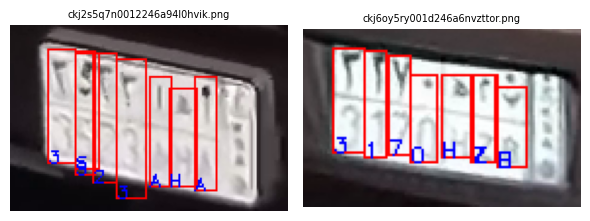

In [35]:
# Display images with overlapping bboxes
overlapping_images = overlapping_df['filename'].values.tolist()
draw_bboxes(overlapping_images, datapath=DATA_PATH, df=df_merge_filterd, folder='train', figsize=(6, 3), plot_row=1, plot_col=2)

In [36]:
#Delete dublicating bboxes
df_merge_filterd.drop(indexes_to_filter[[0,2]], inplace=True)

In [37]:
#Make sure that number of bboxes not more than 7
df_merge_filterd[df_merge_filterd['folder'] == 'train'].groupby('image_name')['class'].count().value_counts()

class
7    453
6     34
4     20
2     18
5     17
3     13
1      8
Name: count, dtype: int64

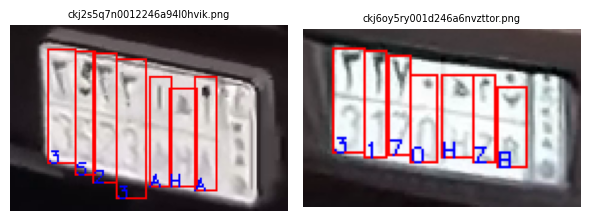

In [38]:
# Display images after deleting overlaping bboxes
draw_bboxes(overlapping_images, datapath=DATA_PATH, df=df_merge_filterd, folder='train', figsize=(6, 3), plot_row=1, plot_col=2)

In [39]:
#Export filtered dataframe
df_merge_filterd.to_csv(os.path.join(DATA_PATH, 'dataset_bboxes_filterd.csv'), index=False)

## Prepare Dataset for YoloV8 <a class="anchor" id="prepare-dataset"></a>

### Creat Train, Valid and Test folders for YOLO training using Stratified Test Split

In [40]:
#Load exported 
df_merge_filtered = pd.read_csv(os.path.join(DATA_PATH, 'dataset_bboxes_filterd.csv'))

In [41]:
from utils.dataset_splitter import onehot_classes

# Create list of classes for each image
df_class_list = df_merge_filtered[df_merge_filtered['folder']=='train'].groupby('filename')['class'].apply(list).reset_index()

# Make one hot encoding for classes for further split
df_class_list = onehot_classes(df_class_list, class_dict)

df_class_list.head(4)

filename                     class    0    1    2  \
0  ckictsenl0000246a2itn28ts.jpeg  [0, 5, 2, 8, 18, 23, 25]  1.0  0.0  1.0   
1  ckictw05s0001246aeel6cew4.jpeg  [3, 2, 5, 2, 12, 18, 11]  0.0  0.0  2.0   
2  ckictycsy0002246ajt63dkm5.jpeg  [3, 6, 9, 0, 16, 11, 10]  1.0  0.0  0.0   
3  ckicu0kmg0003246ab7jnyofh.jpeg  [5, 5, 7, 8, 17, 14, 10]  0.0  0.0  0.0   

     3    4    5    6    7  ...   17   18   19   20   21   22   23   24   25  \
0  0.0  0.0  1.0  0.0  0.0  ...  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0   
1  1.0  0.0  1.0  0.0  0.0  ...  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  1.0  0.0  0.0  1.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.0  0.0  2.0  0.0  1.0  ...  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

    26  
0  0.0  
1  0.0  
2  0.0  
3  0.0  

[4 rows x 29 columns]

In [42]:
#Split train dataset stratified by classes
from utils.dataset_splitter import stratify_shuffle_split_subsets

TRAIN_FRACTION = 0.8
DATASET_MODES = ['train', 'valid', 'test']

x_train, x_valid = stratify_shuffle_split_subsets(df_class_list, TRAIN_FRACTION)
x_test = df_merge_filterd[df_merge_filterd['folder']=='test']['filename'].unique().tolist()

subsets = x_train, x_valid, x_test

print(len(x_train), len(x_valid), len(x_test))

subsets_dict = {}
for name, subset in zip(DATASET_MODES, subsets):
    subsets_dict[name] = subset


445 118 30


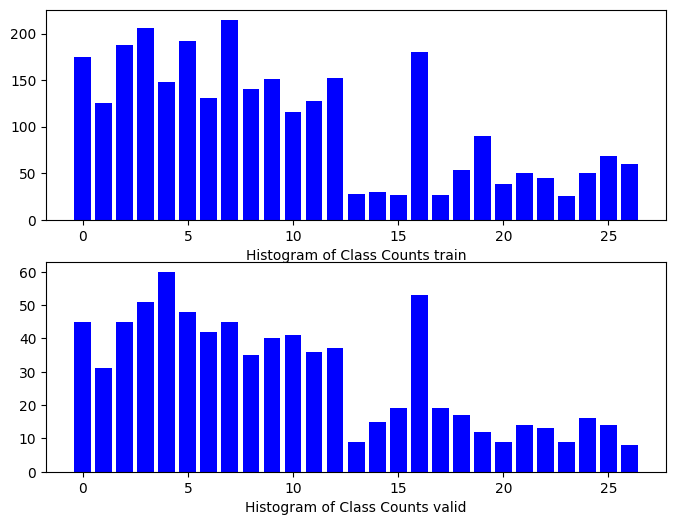

In [43]:
#Class Balance after split
plt.figure(figsize=(8, 6))

for num, subset in enumerate((x_train, x_valid)):
    ax = plt.subplot(2, 1, num + 1)
    class_count = df_merge_filterd[df_merge_filterd['filename'].isin(subset)]['class'].value_counts()
    ax.bar(class_count.index, class_count.values, color='blue')
    ax.set_xlabel('Class ID')
    ax.set_xlabel('Count')
    ax.set_xlabel(f'Histogram of Class Counts {DATASET_MODES[num]}')
plt.show()

Comment: Class proportion between Train and Valid subsets is not ideal decause of small valid size

In [44]:
#Copy files and annotations accourding to YOLO data structure

from utils.copy_to_folders import copy_to_folders

copy_to_folders(DATASET_PATH, DATA_PATH, DATASET_MODES, subsets_dict)

In [45]:
#Check number of files copied is correct
for mode in DATASET_MODES:
    mode = str(mode)
    folder_path = Path('./datasets/images') / mode
    file_count = len([file for file in folder_path.iterdir() if file.is_file()])
    print(file_count)

445
118
30


# Create yaml file

In [46]:
# import yaml
# from pathlib import Path

# # YAML content as specified
# yaml_content = {
#     'path': DATASET_PATH,
#     'train': 'images/train',
#     'val': 'images/valid',
#     'test': 'images/test',
#     'nc': 27,
#     'names': class_dict
# }

# # Path for the YAML file
# yaml_file_path = Path(DATASET_PATH) / 'dataset_plate.yaml'

# # Write the YAML file
# with open(yaml_file_path, 'w') as file:
#     yaml.dump(yaml_content, file)

# yaml_file_path  # Return the path of the created YAML file

## Train YOLOv8 <a class="anchor" id="train-yolo"></a>

In [11]:
model = YOLO("yolov8s.pt")

In [21]:
!yolo task=detect mode=train model=yolov8s.pt data="./datasets/dataset_plate.yaml" epochs=60 imgsz=320 batch=16 device=0 plots=True max_det=7 fliplr=0 close_mosaic=0

Ultralytics YOLOv8.1.14 🚀 Python-3.9.10 torch-2.0.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine\trainer: task=detect, mode=train, model=yolov8s.pt, data=C:\Users\julia\CV\RUDCODE_task\datasets\dataset_plate.yaml, epochs=60, time=None, patience=50, batch=16, imgsz=320, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train6, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=0, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=7, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, sav


train: Scanning C:\Users\julia\CV\RUDCODE_task\datasets\labels\train.cache... 445 images, 0 backgrounds, 0 corrupt: 100%|██████████| 445/445 [00:00<?, ?it/s]
train: Scanning C:\Users\julia\CV\RUDCODE_task\datasets\labels\train.cache... 445 images, 0 backgrounds, 0 corrupt: 100%|██████████| 445/445 [00:00<?, ?it/s]

val: Scanning C:\Users\julia\CV\RUDCODE_task\datasets\labels\valid.cache... 118 images, 0 backgrounds, 0 corrupt: 100%|██████████| 118/118 [00:00<?, ?it/s]
val: Scanning C:\Users\julia\CV\RUDCODE_task\datasets\labels\valid.cache... 118 images, 0 backgrounds, 0 corrupt: 100%|██████████| 118/118 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]
       1/60      1.32G      3.921      5.561      2.769        191        320:   0%|          | 0/28 [00:02<?, ?it/s]
       1/60      1.32G      3.921      5.561      2.769        191        320:   4%|▎         | 1/28 [00:02<01:02,  2.33s/it]
       1/60      1.32G      3.792      5.845      2.678        202        320:   4%|▎ 

Link to CLearMl for the experiment

https://app.clear.ml/projects/5429d91bbfde4c589d7c1a9dd1f8ebad/experiments/242efa68913b4e7d8ebd6fa6a2b61be8/output/execution


### Result of Training

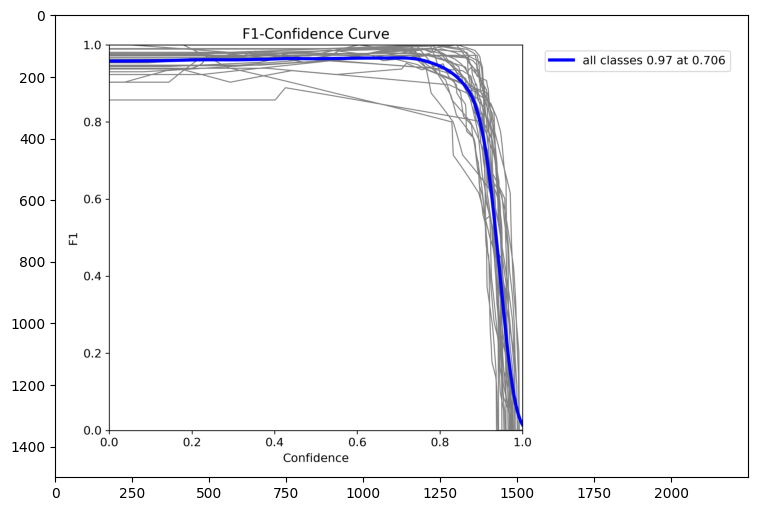

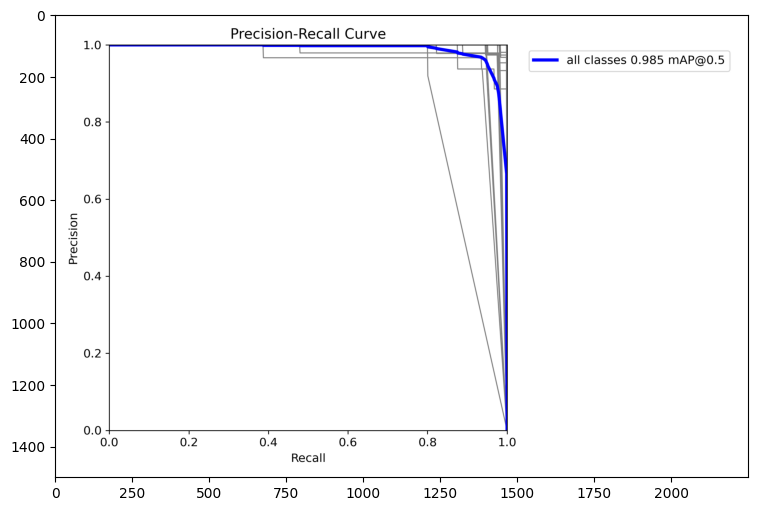

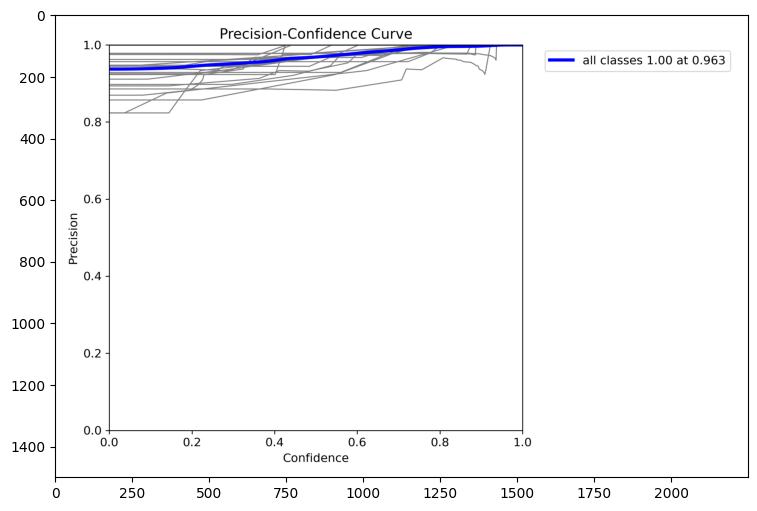

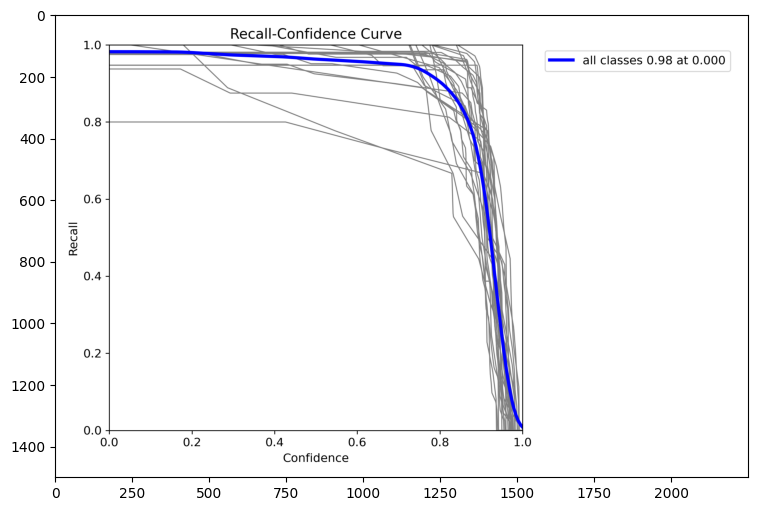

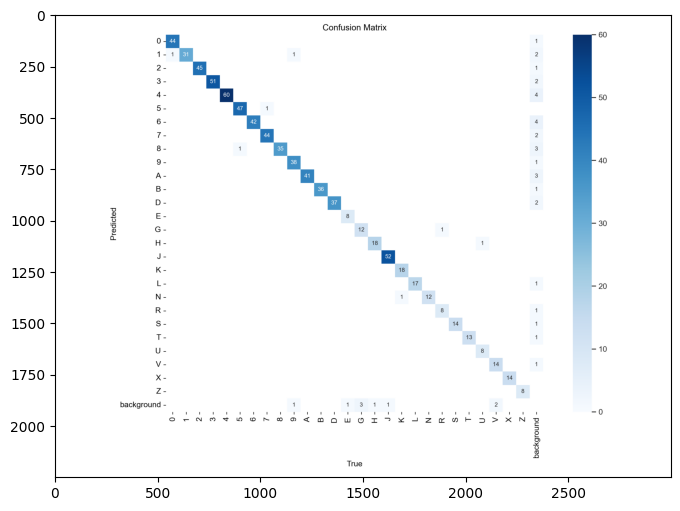

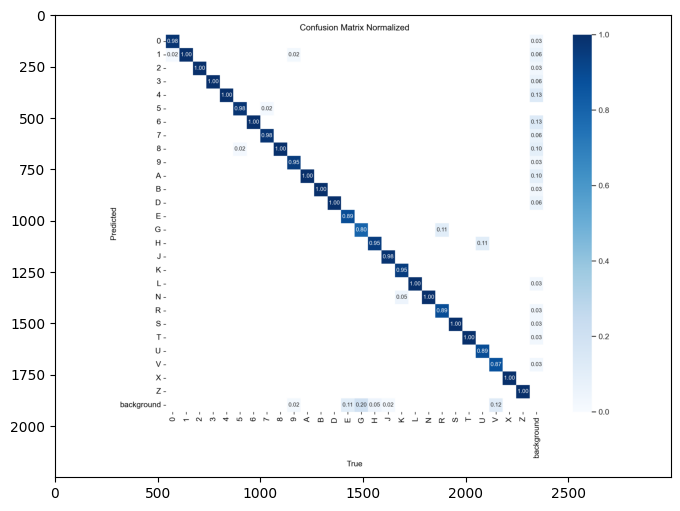

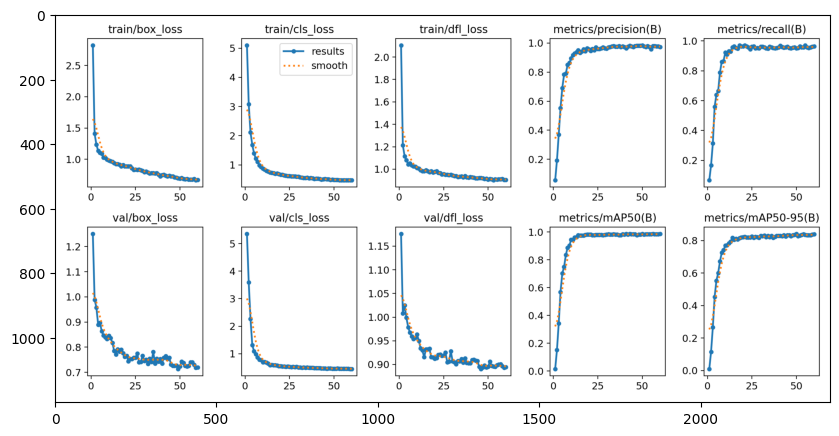

In [49]:
#Visualize training results
TRAIN_RESULTS_PATH = "./runs/detect/train"

tpaths2=[]
for dirname, _, filenames in os.walk(TRAIN_RESULTS_PATH):
    for filename in filenames:
        if filename[-4:]=='.png':
            tpaths2+=[(os.path.join(dirname, filename))]
tpaths2=sorted(tpaths2)

for path in tpaths2:
    image = Image.open(path)
    image=np.array(image)
    plt.figure(figsize=(10,6))
    plt.imshow(image)
    plt.show()

./runs/detect/train6\train_batch1.jpg


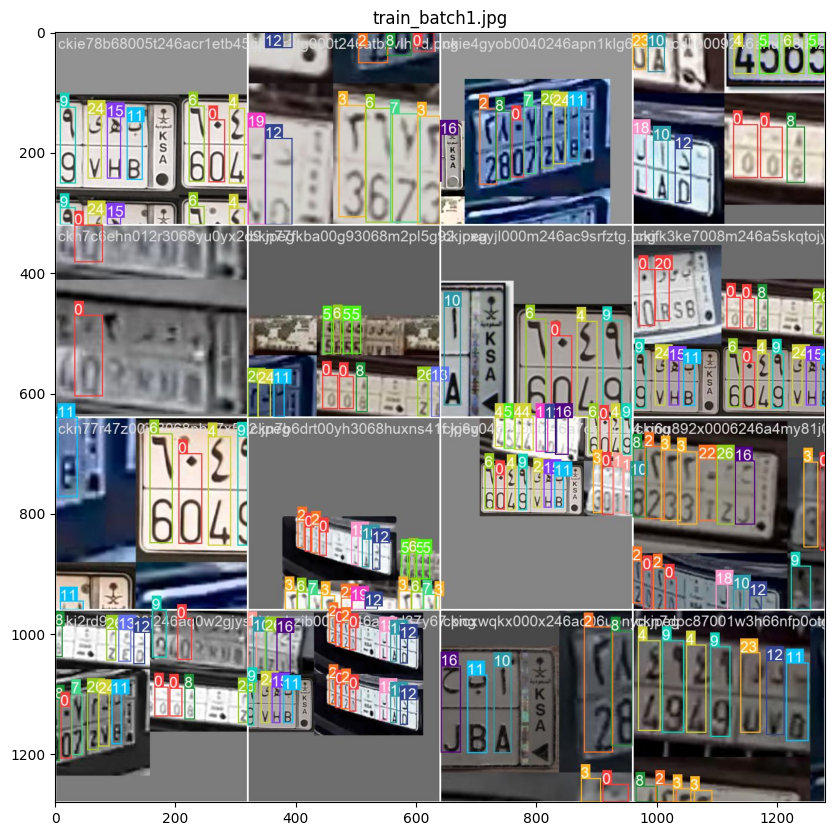

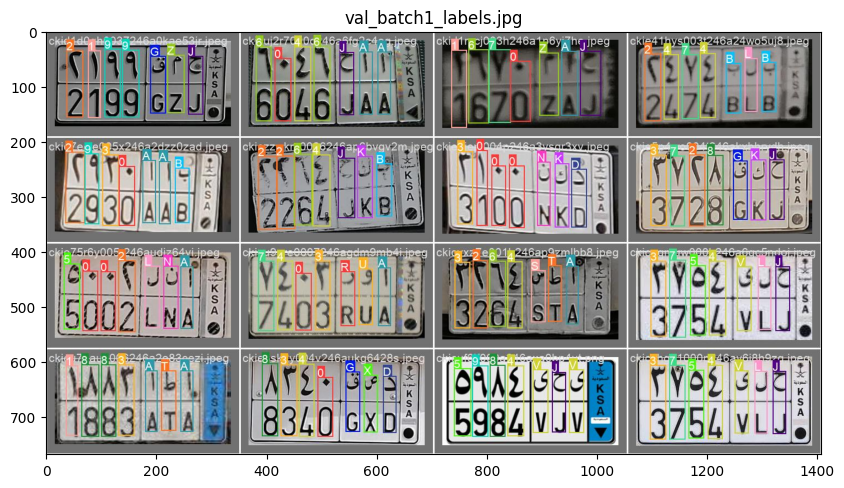

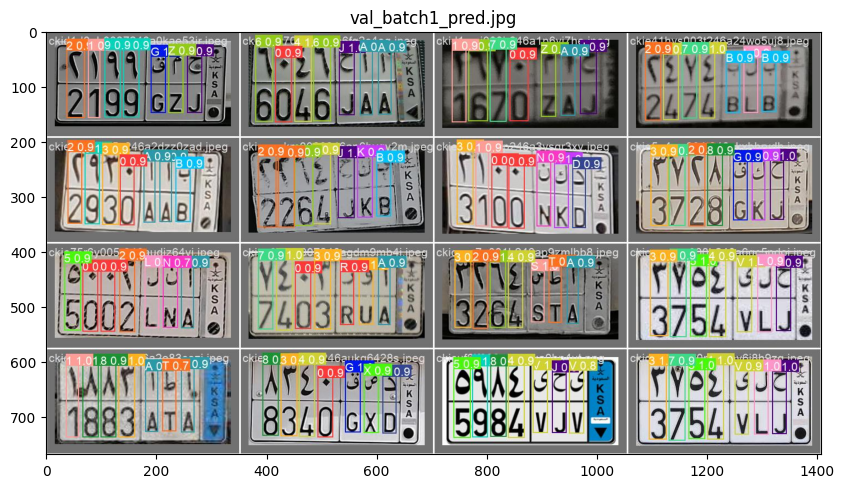

In [52]:
#Visualize batch images
tpaths2=[]
for dirname, _, filenames in os.walk(TRAIN_RESULTS_PATH):
    for filename in filenames:
        if filename[-4:]=='.jpg' and "batch1" in filename:
            tpaths2+=[(os.path.join(dirname, filename))]
tpaths2=sorted(tpaths2)
print(tpaths2[0])

for path in tpaths2:
    image = Image.open(path)
    image=np.array(image)
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    plt.title(path.split('\\')[-1])
    plt.show()

## TEST Dataset Validation <a class="anchor" id="test-dataset"></a>

In [83]:
!yolo task=detect mode=val model="./runs/detect/train/weights/best.pt" data="./datasets/dataset_plate.yaml" save_json=True max_det=7 plots=True split=test

Ultralytics YOLOv8.1.14 🚀 Python-3.9.10 torch-2.0.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
Model summary (fused): 168 layers, 11136033 parameters, 0 gradients, 28.5 GFLOPs
                   all         30        199      0.929      0.994      0.974      0.817
                     0         30          5          1          1      0.995      0.824
                     1         30          2          1          1      0.995      0.734
                     2         30         12      0.922      0.991      0.989      0.818
                     3         30         12      0.857          1      0.989      0.743
                     4         30         17      0.944          1      0.989      0.813
                     5         30         21          1          1      0.995      0.849
                     6         30          8          1          1      0.995      0.789
                     7         30         16          1          1      0.995      0.768
       


val: Scanning C:\Users\julia\CV\RUDCODE_task\datasets\labels\test.cache... 30 images, 0 backgrounds, 0 corrupt: 100%|██████████| 30/30 [00:00<?, ?it/s]
val: Scanning C:\Users\julia\CV\RUDCODE_task\datasets\labels\test.cache... 30 images, 0 backgrounds, 0 corrupt: 100%|██████████| 30/30 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:02<00:02,  2.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.55s/it]


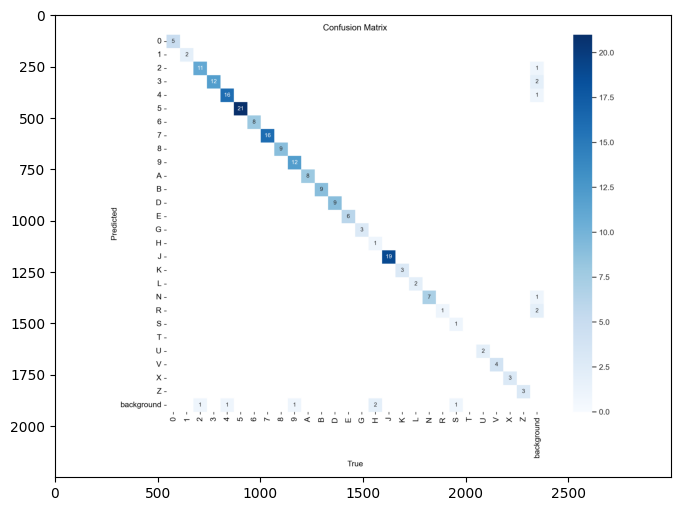

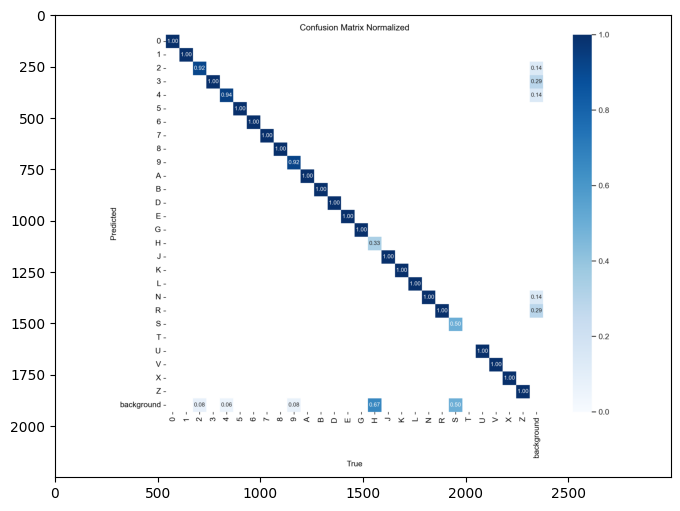

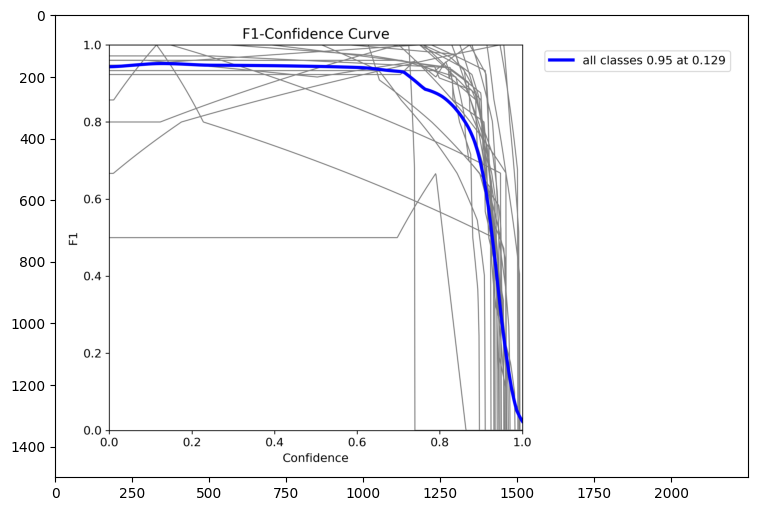

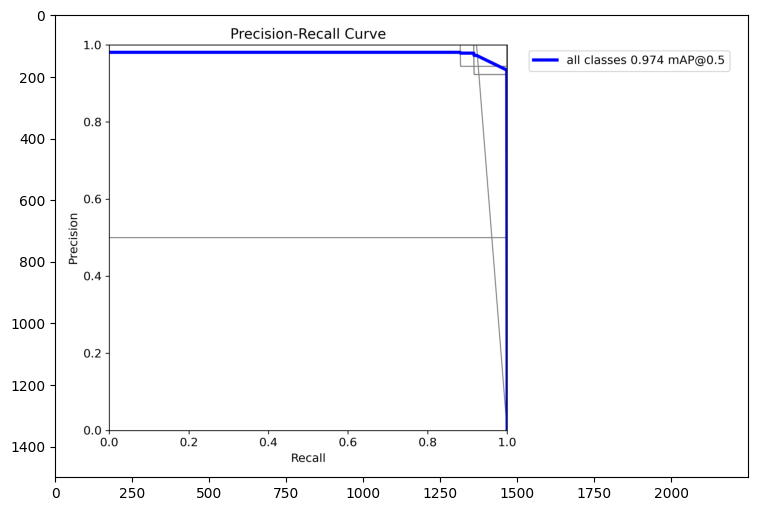

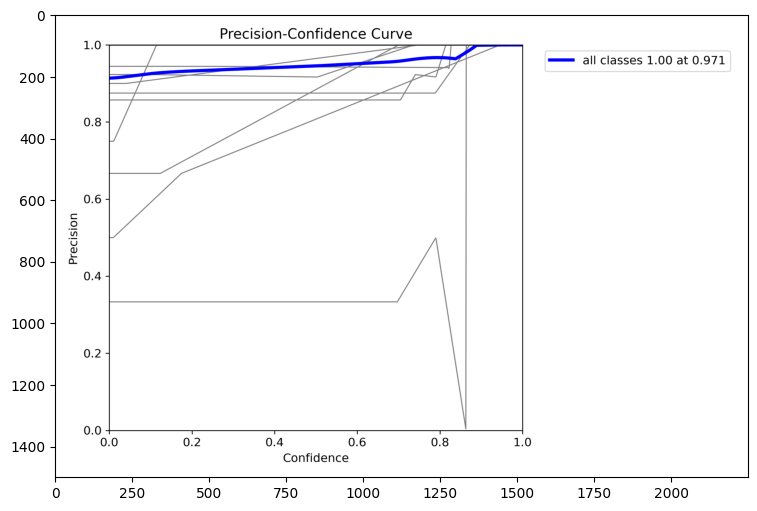

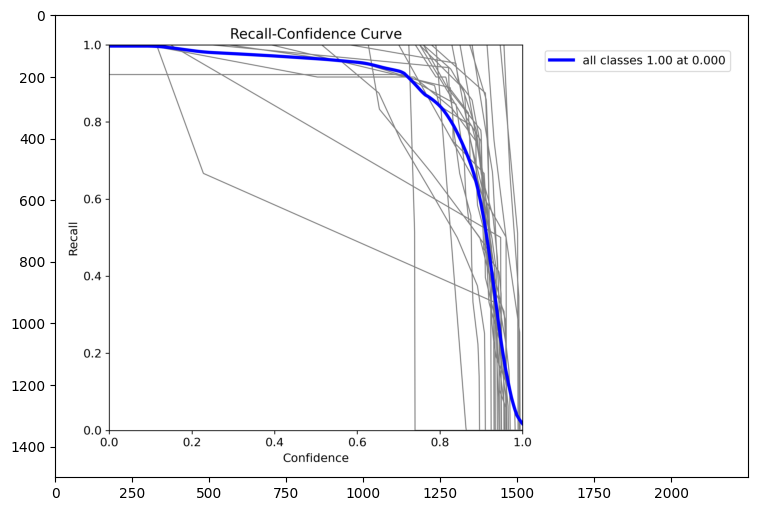

In [62]:
#Visualize TEST results
VAL_RESULTS_PATH = "./runs/detect/val"

tpaths2=[]
for dirname, _, filenames in os.walk(VAL_RESULTS_PATH):
    for filename in filenames:
        if filename[-4:]=='.png':
            tpaths2+=[(os.path.join(dirname, filename))]

for path in tpaths2:
    image = Image.open(path)
    image=np.array(image)
    plt.figure(figsize=(10,6))
    plt.imshow(image)
    plt.show()

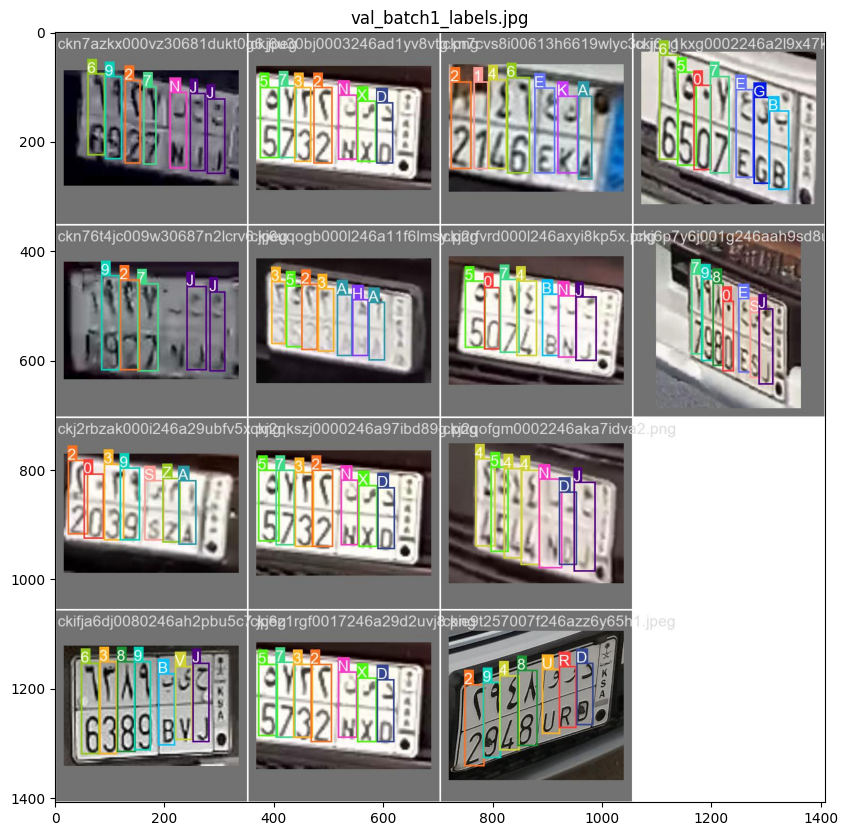

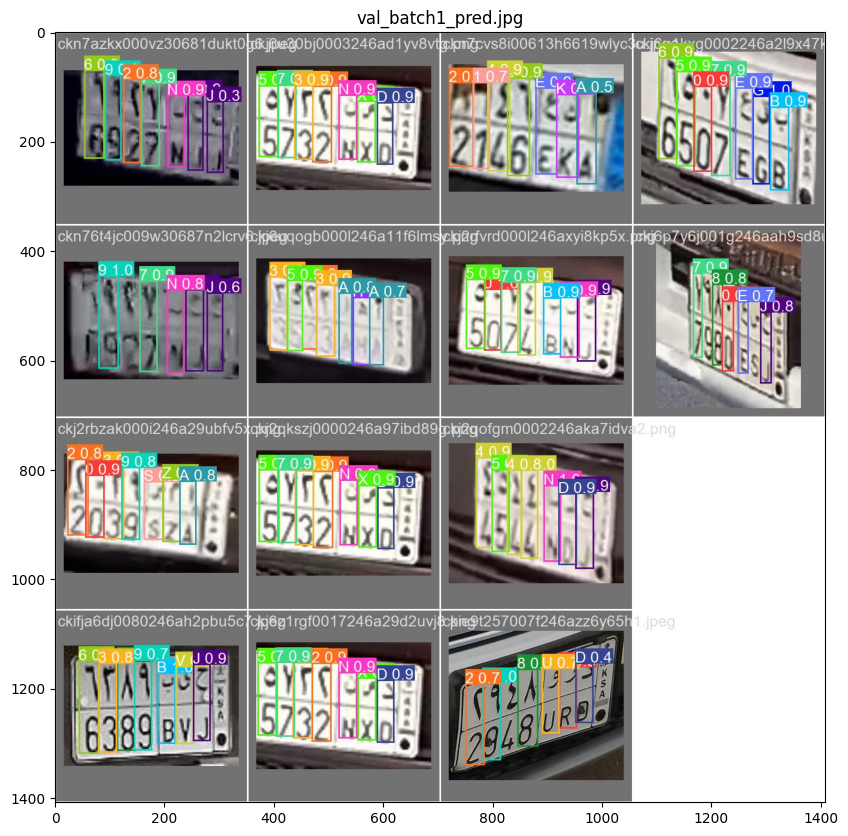

In [63]:
#Visualize TEST prediction batch images
tpaths2=[]
for dirname, _, filenames in os.walk(VAL_RESULTS_PATH):
    for filename in filenames:
        if filename[-4:]=='.jpg' and "batch1" in filename:
            tpaths2+=[(os.path.join(dirname, filename))]
tpaths2=sorted(tpaths2)

for path in tpaths2:
    image = Image.open(path)
    image=np.array(image)
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    plt.title(path.split('\\')[-1])
    plt.show()

## Inference <a class="anchor" id="inference"></a>

In [76]:
BEST_MODEL = "./runs/detect/train/weights/best.pt"
SAVE_IMAGE = './inference_results/result.jpg'
# Load a model
model = YOLO(BEST_MODEL)  # pretrained YOLOv8n model

# Run batched inference on a list of images
images_paths = os.path.join(DATA_PATH, 'test', x_test[0])

results = model([images_paths])  # return a list of Results objects

# Process results list
for result in results:
    boxes = result.boxes  # Boxes object for bounding box outputs
    result.show()  # display to screen
    result.save(filename=SAVE_IMAGE)  # save to disk

results[0].boxes.data


0: 160x320 1 0, 1 4, 2 6s, 2 As, 1 J, 18.0ms
Speed: 1.0ms preprocess, 18.0ms inference, 1.0ms postprocess per image at shape (1, 3, 160, 320)


tensor([[ 83.3878,   9.7146, 114.4140, 146.4541,   0.9619,   4.0000],
        [164.2849,  19.3899, 192.8337, 134.8615,   0.9552,  16.0000],
        [117.9700,   9.1964, 149.4658, 145.9234,   0.9442,   6.0000],
        [202.6204,  17.8384, 226.0006, 135.1332,   0.9408,  10.0000],
        [236.3905,  16.9233, 259.6667, 133.9952,   0.9308,  10.0000],
        [ 12.4164,  10.2266,  44.3748, 146.8212,   0.9063,   6.0000],
        [ 48.4327,  28.2550,  78.5483, 146.9849,   0.8984,   0.0000]], device='cuda:0')

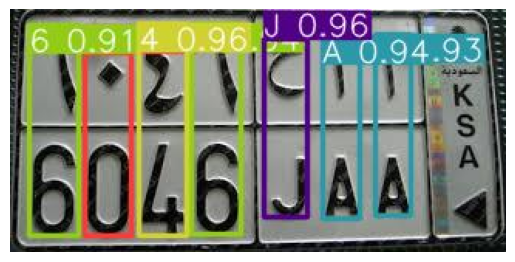

In [5]:
image = cv2.imread(SAVE_IMAGE)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.axis('off')
plt.show()